In [3]:
import pandas as pd
import numpy as np

import plotnine as p
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_light, scale_color_manual, theme, guides, element_text

import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [9]:
df = pd.read_csv('data/final_with_treat.csv')
df

,QUESTID2,AUN_SUM,AUUNCOST,AUUNNCOV,AUUNENUF,AUUN_ANY,TXEVER,TXYREVER,AUPOPAMT,AGE2,...,COCYR,EDUCCAT2,JBSTATR2,HEALTH,K6SCMON,PRVHLTIN,GRPHLTIN,YEAR,Treatment,Post
0,2013_53815143,0.0,NaN,NaN,NaN,0,2.0,2.0,NaN,15,...,0,3.0,1.0,3.0,9.0,1.0,1.0,2013,1,1
1,2013_47035143,0.0,NaN,NaN,NaN,0,2.0,2.0,NaN,2,...,0,5.0,99.0,5.0,NaN,2.0,2.0,2013,0,1
2,2013_55565143,0.0,NaN,NaN,NaN,0,2.0,2.0,NaN,11,...,0,1.0,7.0,5.0,0.0,2.0,2.0,2013,0,1
3,2013_83765143,0.0,NaN,NaN,NaN,0,2.0,2.0,NaN,13,...,0,4.0,1.0,5.0,4.0,1.0,1.0,2013,1,1
4,2013_91965143,0.0,NaN,NaN,NaN,0,2.0,2.0,NaN,15,...,0,1.0,9.0,3.0,0.0,2.0,2.0,2013,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873398,2009_67814730,0.0,NaN,NaN,NaN,0,2.0,2.0,NaN,5,...,0,5.0,7.0,5.0,NaN,2.0,2.0,2009,0,0
873399,2009_35824730,0.0,NaN,NaN,NaN,0,2.0,2.0,NaN,10,...,0,2.0,9.0,5.0,0.0,2.0,2.0,2009,0,0
873400,2009_73024730,0.0,NaN,NaN,NaN,0,2.0,2.0,NaN,15,...,0,3.0,1.0,4.0,0.0,1.0,1.0,2009,1,0
873401,2009_65344730,0.0,NaN,NaN,NaN,0,1.0,1.0,NaN,9,...,0,2.0,2.0,4.0,1.0,2.0,2.0,2009,0,0


In [5]:
df.columns

Index(['AUN_SUM', 'AUUN_ANY', 'HEALTH', 'K6SCMON', 'Treatment', 'Post', 'AGE2',
       'IRSEX', 'INCOME', 'IRMARIT', 'SERVICE', 'CG30EST', 'AL30EST',
       'IRHHSIZ2', 'NOBOOKY2', 'COCFLAG', 'COCYR', 'EDUCCAT2', 'JBSTATR2',
       'TXEVER', 'TXYREVER'],
      dtype='object')

In [10]:
y_vars = ["AUN_SUM", "HEALTH", "K6SCMON"]

# Parallel Pre-trends Assumption

## Graphical Analysis

In [7]:
# Plotnine 플롯 생성
for y_var in y_vars:
    plot = (
        ggplot(grouped_data[grouped_data['Variable'] == y_var], aes(x='YEAR', y='Value', color='factor(Treatment)')) +
        geom_line(aes(linetype='factor(Treatment)')) +
        geom_point(size=2) +
        labs(
            title=f'Yearly Trends of {y_var}',
            x='Year',
            y=y_var,
            color='Group (Treatment)'  # 색상 범례 레이블
        ) +
        scale_color_manual(values=['blue', 'orange'], labels=['Control Group', 'Treatment Group']) +
        guides(linetype=False) +  # 불필요한 linetype 범례 제거
        theme_light() +
        theme(
            figure_size=(10, 6),  # 플롯 크기 설정
            plot_title=element_text(size=15)  # 제목 크기와 볼드 처리
        )
    )
    print(plot)  # Use print to render the plot


NameError: name 'grouped_data' is not defined

## Statistical Analysis

In [8]:
# Event Study Plot 생성
for y_var in y_vars:
    # 회귀식 정의
    formula = f"{y_var} ~ C(Treatment)*C(YEAR)"
    
    # OLS 회귀 분석
    reg = smf.ols(formula, data=df).fit()
    
    # 계수 필터링: 상호작용 계수만 추출
    interaction_params = reg.params.filter(like='C(Treatment)[T.1]:C(YEAR)')
    interaction_bse = reg.bse.filter(like='C(Treatment)[T.1]:C(YEAR)')
    
    # 연도 추출 (계수 이름에서 연도 파싱)
    years = interaction_params.index.str.extract(r'C\(YEAR\)\[T\.(\d+)\]')[0].astype(int)
    
    # 플롯 데이터 준비
    plot_data = pd.DataFrame({
        'year': years,
        'mean': interaction_params.values,
        'sd': interaction_bse.values
    }).sort_values('year')  # 연도 정렬
    
    plot_data['lb'] = plot_data['mean'] - 1.96 * plot_data['sd']
    plot_data['ub'] = plot_data['mean'] + 1.96 * plot_data['sd']
    
    # Event Study Plot 생성
    plot = (
        p.ggplot(plot_data, p.aes(x='year', y='mean')) +
        p.geom_hline(yintercept=0, linetype='dashed', color='black') +
        p.geom_errorbar(p.aes(ymin='lb', ymax='ub'), width=0.2, color='gray') +
        p.geom_point(color='blue', size=2) +
        p.labs(
            title=f"Event Study Plot for {y_var}",
            x="Year",
            y="Estimated Effect"
        ) +
        p.theme_light() +
        p.theme(
            figure_size=(10, 6),
            plot_title=p.element_text(size=16, face='bold'),
            axis_title=p.element_text(size=12)
        )
    )
    print(plot)  # Use print to render the plot


PatsyError: Error evaluating factor: NameError: name 'YEAR' is not defined
    AUN_SUM ~ C(Treatment)*C(YEAR)
                           ^^^^^^^

# Estimating Causal Effects

## Without Controls

### DiD

$$
Y_{it} = \beta_0 + \beta_1 \text{Treatment}_i + \beta_2 \text{Post}_t + \beta_3 (\text{Treatment}_i \times \text{Post}_t) + \epsilon_{it}
$$

1. $Y_{it}$:
   - 개체 $i$와 시간 $t$에서의 종속 변수 (예: `HEALTH`, `K6SCMON`, `AUPOPAMT`).

2. $\beta_0$:
   - 상수항(Intercept), 기본값.

3. $\beta_1 \text{Treatment}_i$:
   - 처치 집단과 비처치 집단 간의 (시간과 관련없는) 평균적 차이

4. $\beta_2 \text{Post}_t$:
   - 처치 이후 기간 ($\text{Post}_t = 1$)과 처치 이전 기간 ($\text{Post}_t = 0$) 간의 평균 차이
   - 이는 시간에 따른 외부 요인의 영향을 반영

5. $\beta_3 (\text{Treatment}_i \times \text{Post}_t)$:
   - Difference-in-Differences 상호작용 항으로, 처치 집단이 처치 이후에 경험하는 추가적인 효과
   - $\beta_3$가 는 우리가 추정하고자 하는 **처치의 인과적 효과**

6. $\epsilon_{it}$:
   - 오류항(Error term)으로, 관측되지 않은 요인이나 설명되지 않은 변화를 포함

---
- $\beta_3$가 처치의 인과적 효과(Causal Effect)를 추정
- $\beta_3 > 0$: 처치가 종속 변수 $Y$를 긍정적으로 변화시켰음을 의미
- $\beta_3 < 0$: 처치가 종속 변수 $Y$를 부정적으로 변화시켰음을 의미
- $\beta_3 = 0$: 처치가 종속 변수 $Y$에 영향을 미치지 않았음을 의미

In [19]:
def run_did_analysis(df, y_var):
    formula = f"{y_var} ~ Treatment + Post + Treatment*Post"
    model = smf.ols(formula, data=df).fit()
    print(f"\n=== DiD Analysis for {y_var} ===")
    print(model.summary())

# 각 Y 변수에 대해 DiD 분석 실행
for y_var in y_vars:
    run_did_analysis(df, y_var)


=== DiD Analysis for AUN_SUM ===
                            OLS Regression Results                            
Dep. Variable:                AUN_SUM   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     194.8
Date:                Fri, 06 Dec 2024   Prob (F-statistic):          2.56e-126
Time:                        15:55:17   Log-Likelihood:            -2.1921e+06
No. Observations:              873403   AIC:                         4.384e+06
Df Residuals:                  873399   BIC:                         4.384e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 


=== DiD Analysis for AUUN_ANY ===
                            OLS Regression Results                            
Dep. Variable:               AUUN_ANY   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     445.7
Date:                Fri, 06 Dec 2024   Prob (F-statistic):          2.23e-289
Time:                        15:55:18   Log-Likelihood:             3.9262e+05
No. Observations:              873403   AIC:                        -7.852e+05
Df Residuals:                  873399   BIC:                        -7.852e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept

### Semiparametric DiD

1. **Propensity Score 추정**:
   - `LogisticRegression`을 사용해 `Treatment`를 공변량으로 예측.
   - 추정된 처치 확률을 `propensity_score` 열에 저장.

2. **가중치 계산**:
   - 처치 집단: $ w_i = \frac{1}{\text{propensity\_score}_i} $
   - 비처치 집단: $ w_i = \frac{1}{1 - \text{propensity\_score}_i} $

In [50]:
covariates = df.columns.difference(['Treatment', 'Post', 'YEAR', 'DiD', 'QUESTID2', 'PRVHLTIN', 'GRPHLTIN', 'year_dummy'])
non_missing_covariates = df[covariates].dropna(axis=1).columns.tolist()

# Propensity Score 추정
logit = LogisticRegression()
X = df[non_missing_covariates] 
y = df['Treatment']
logit.fit(X, y)
df['propensity_score'] = logit.predict_proba(X)[:, 1]

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


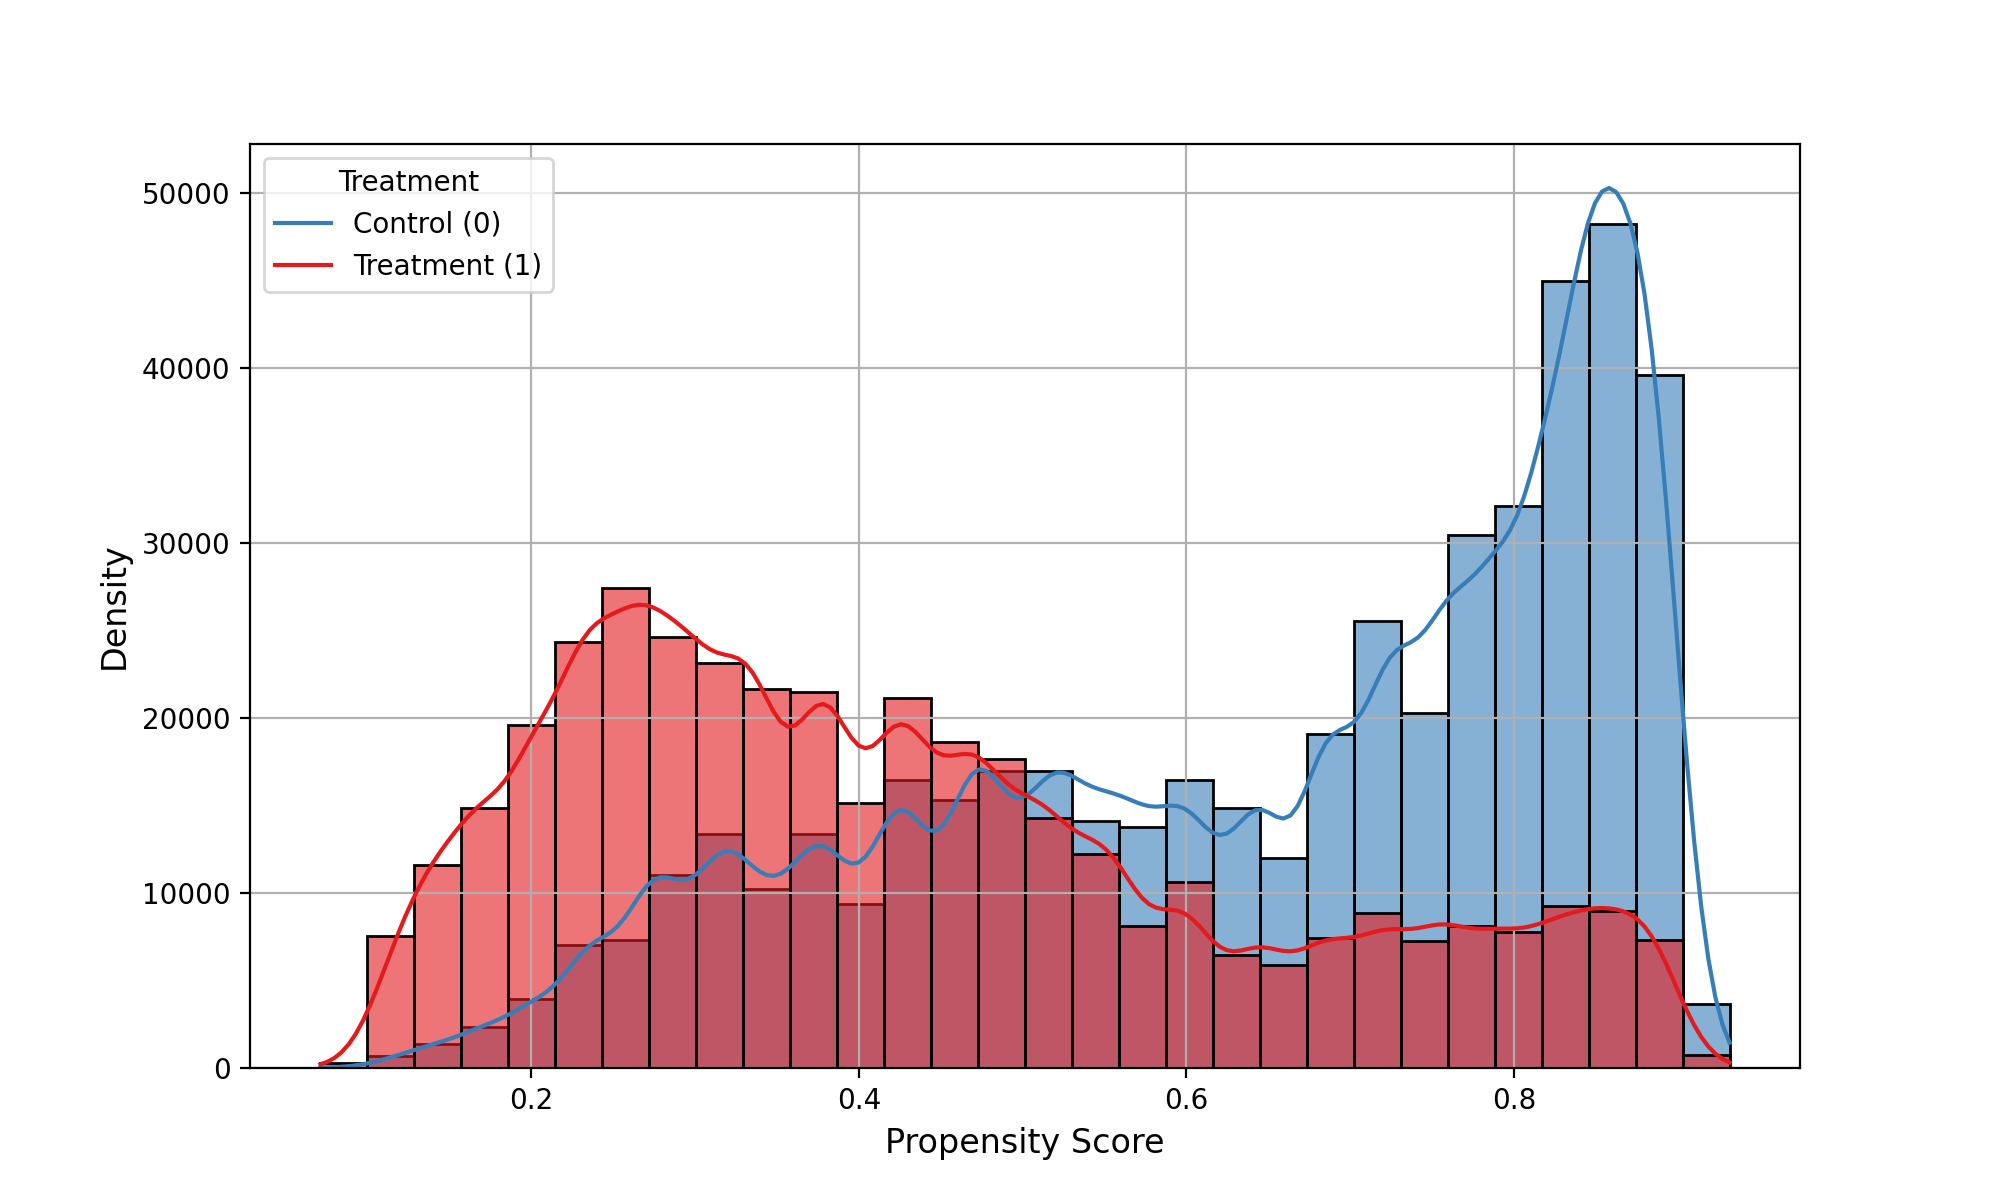

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df, 
    x='propensity_score', 
    hue='Treatment', 
    kde=True, 
    bins=30, 
    palette='Set1', 
    alpha=0.6
)
plt.xlabel('Propensity Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Treatment', labels=['Control (0)', 'Treatment (1)'])
plt.grid(True)
plt.show()

**Weights**

In [51]:
df['semi_weight'] = np.where(
    df['Treatment'] == 1,
    1 / df['propensity_score'],  # 처치 집단 가중치
    1 / (1 - df['propensity_score'])  # 비처치 집단 가중치
)

In [52]:
y_vars_semi = ['AUN_SUM', 'AUPOPAMT', 'AUUNNCOV', 'AUUNENUF', 'K6SCMON', 'AUUNCOST', 'AUUN_ANY']

**Weighted Trends**

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/opt/anaconda3/lib/python3.9/site-packages/s

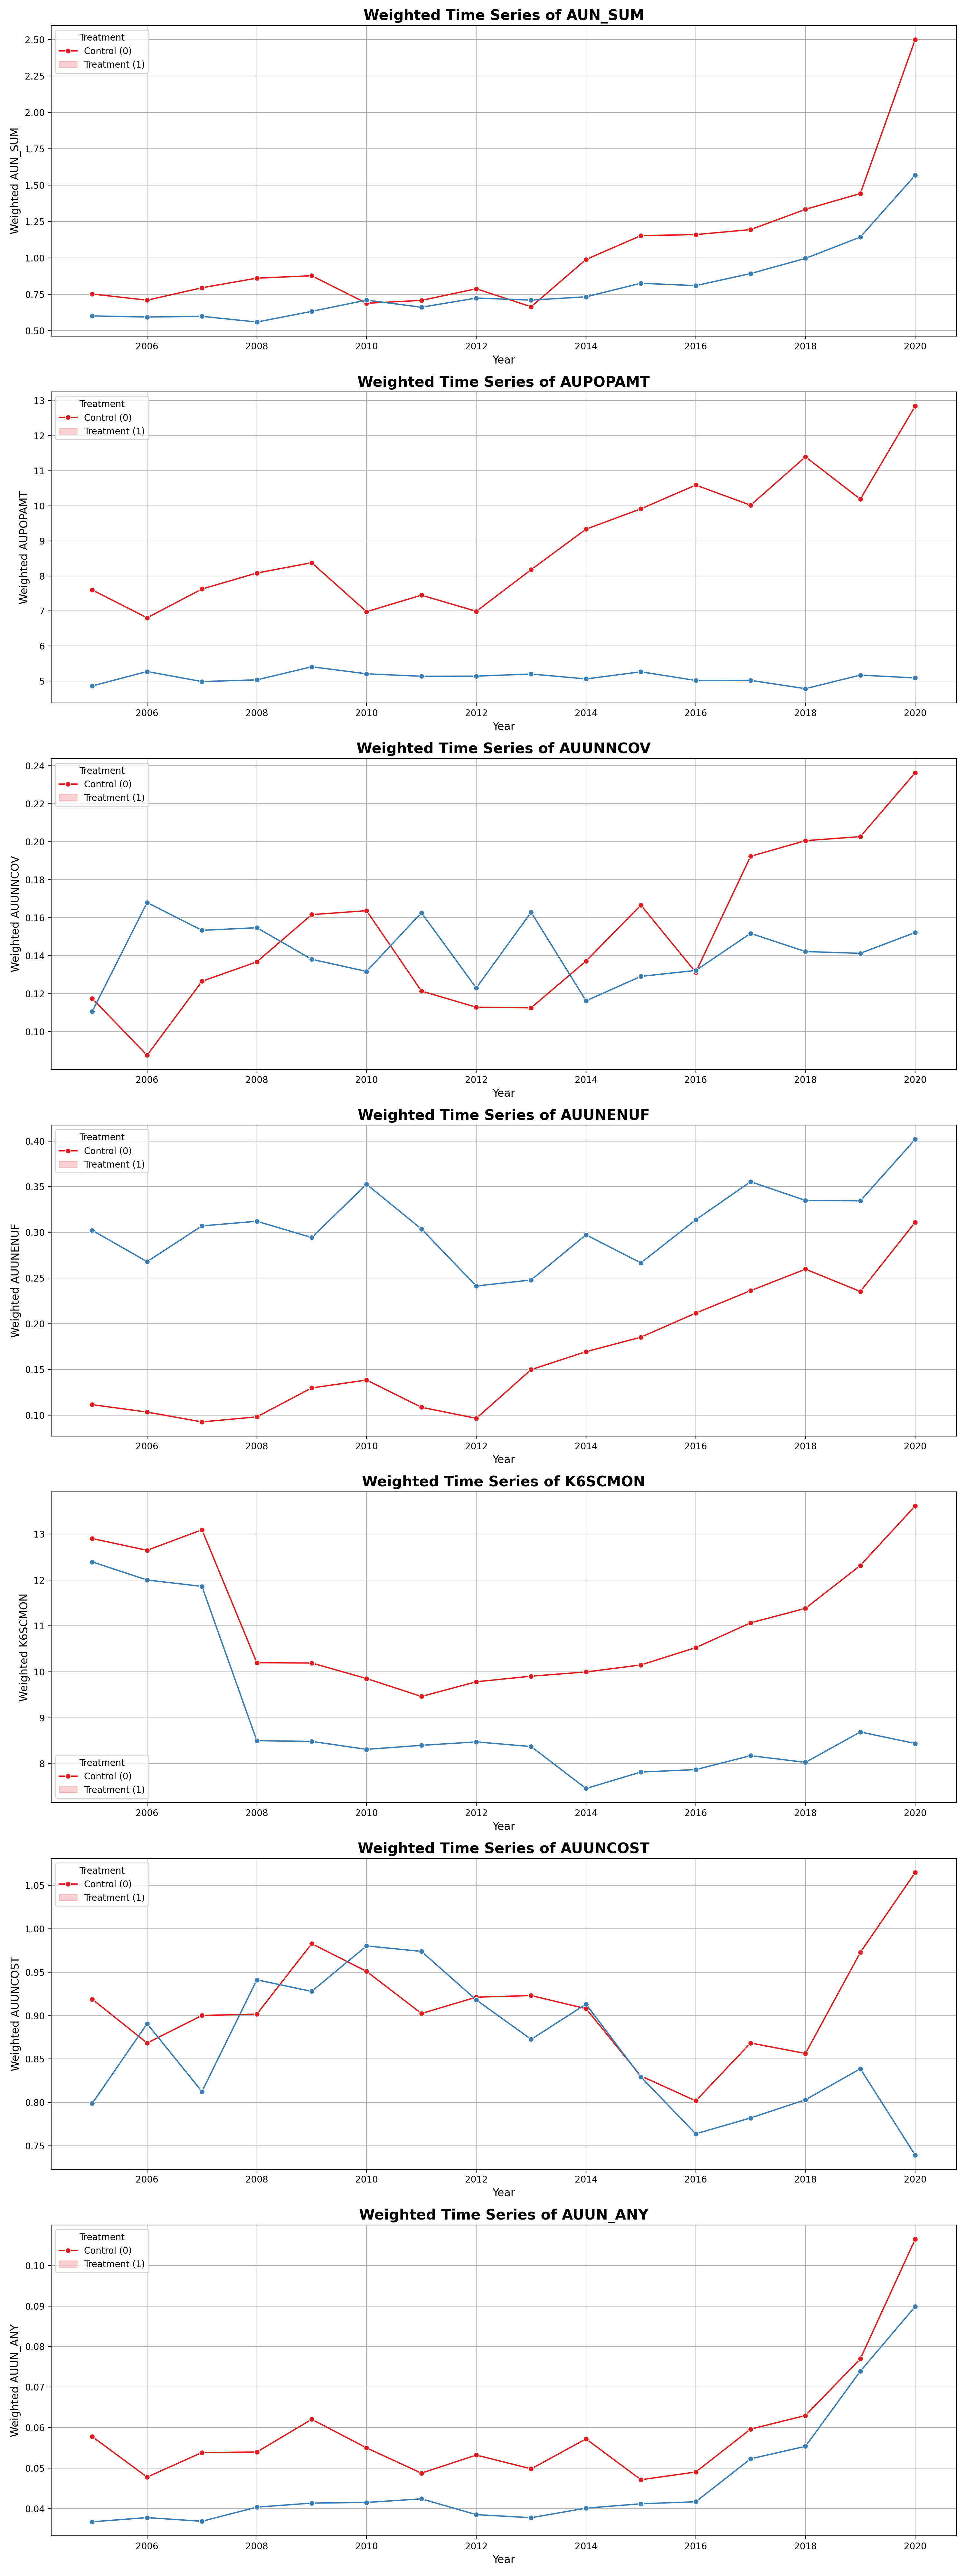

In [59]:
plt.figure(figsize=(15, 40))

# Loop through each variable in y_vars_semi
for i, y_var in enumerate(y_vars_semi, 1):
    # Calculate weighted Y values
    df[f'weighted_{y_var}'] = df[y_var] * df['semi_weight']  # Single y_var calculation
    
    # Compute yearly averages grouped by Treatment
    weighted_means = (
        df.groupby(['YEAR', 'Treatment'])[f'weighted_{y_var}']
        .mean()
        .reset_index()
    )

    # Create a subplot for each variable
    ax = plt.subplot(len(y_vars_semi), 1, i)
    sns.lineplot(
        data=weighted_means,
        x='YEAR',
        y=f'weighted_{y_var}',
        hue='Treatment',
        marker='o',
        palette='Set1',
        ax=ax  # Use the subplot axis
    )
    
    # Set titles and labels for the subplot
    ax.set_title(f'Weighted Time Series of {y_var}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel(f'Weighted {y_var}', fontsize=12)
    ax.grid(True)
    ax.legend(title='Treatment', labels=['Control (0)', 'Treatment (1)'], fontsize=10)

# Adjust overall layout
plt.tight_layout()
plt.show()


In [62]:
y_vars_semi = ['weighted_AUN_SUM', 'weighted_AUPOPAMT', 'weighted_AUUNNCOV', 'weighted_AUUNENUF', 'weighted_K6SCMON', 'weighted_AUUNCOST', 'weighted_AUUN_ANY']

**Weighted Results**

In [63]:
for y_var in y_vars_semi:
    run_did_analysis(df, y_var)


=== DiD Analysis for weighted_AUN_SUM ===
                            OLS Regression Results                            
Dep. Variable:       weighted_AUN_SUM   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     131.2
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           5.73e-85
Time:                        16:23:35   Log-Likelihood:            -3.0581e+06
No. Observations:              873403   AIC:                         6.116e+06
Df Residuals:                  873399   BIC:                         6.116e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
I


=== DiD Analysis for weighted_K6SCMON ===
                            OLS Regression Results                            
Dep. Variable:       weighted_K6SCMON   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2281.
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:23:36   Log-Likelihood:            -2.4878e+06
No. Observations:              623357   AIC:                         4.976e+06
Df Residuals:                  623353   BIC:                         4.976e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
I

## With Controls